In [ ]:
"""
How to register forward and backward hooks using ResNet-18

Hooks: A technique to run other code when a specific event occur
To calculate Grad-CAM, this hooks get the gradient value when the forward and backward propagation occurs on the last convolutional layer
"""

import torch

class GradCAM:
    # GradCAM class initialization
    # model: ResNet-18
    # main, sub: layer 4, conv 2
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub)

    # register hooks
    def register_hook(self, main, sub):
        # iterate over the names of modules in the model
        for name, module in self.model.named_children():
            if name == main:
                # iterate over the names of layers in the main module
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        # register forward and backward hook
                        sub_module.register_forward_hook(self.forward_hook)
                        sub_module.register_full_backward_hook(self.backward_hook)

    # get the feature map of the last convolutional layer
    def forward_hook(self, module, input, output):
        self.feature_map = output

    # get the gradient of the last convolutional layer
    def backward_hook(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

    # generate Grad-CAM
    def __call__(self, x):
        output = self.model(x) # output of the model [N,1000]
        index = output.argmax(axis=1) # extract the index assigned to the highest class
        one_hot = torch.zeros_like(output) # apply one-hot encoding
        # assign a value of 1 to the highest index
        for i in range(output.size(0)): #
            one_hot[i][index[i]] = 1
        self.model.zero_grad() # init gradient
        output.backward(gradient=one_hot, retain_graph=True) # back propagation
        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True) # calculate alpha
        grad_cam = torch.sum(a_k * self.feature_map, dim=1) # sum of weighted feature map
        grad_cam = torch.relu(grad_cam) # relu
        return grad_cam


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


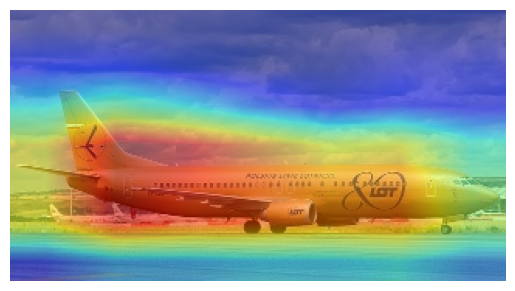

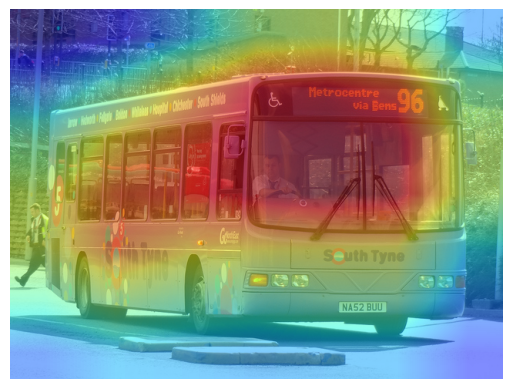

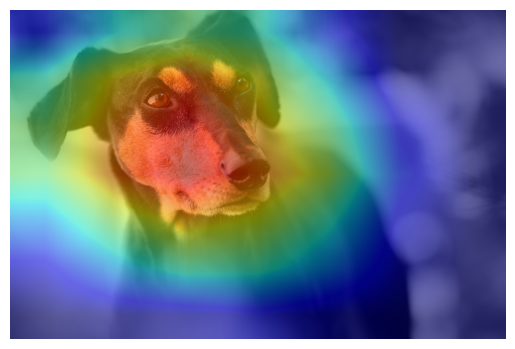

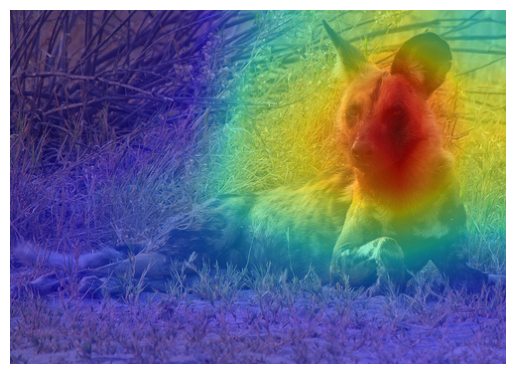

In [ ]:
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt

# prepare input images
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "./airplane.jpeg", "./bus.jpeg",
    "./dog.jpeg", "./african_hunting_dog.jpeg"
]

images, tensors = [], []
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors)

# use GradCAM class
model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main="layer4",
    sub="conv2"
)

# GradCAM ouput
grad_cams = model(tensors)

# enumerate over images to visualize
for idx, image in enumerate(images):
    grad_cam = F.interpolate(
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    ).squeeze().detach().numpy()

    plt.imshow(image)
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()